In [3]:
import os
import numpy as np
import pandas as pd
import json

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
all_stats = []
for fn in os.listdir('train_logs_single_run'):
    if fn.endswith('.json'):
        all_stats.append(json.load(open(os.path.join('train_logs_single_run', fn), 'r')))

In [6]:
len(all_stats)

14322

In [7]:
def get_nodes_cnt(x):
    all_nodes = set(x.keys())
    for k in x.keys():
        all_nodes |= set(x[k]['input'])
    return len(all_nodes)

Text(0, 0.5, 'Number of architectures')

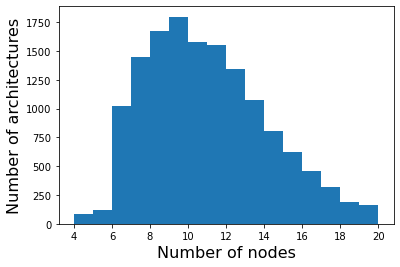

In [8]:
plt.hist([get_nodes_cnt(json.loads(x['recepie'])) for x in all_stats], bins=16, range=(4, 20))
plt.xlabel('Number of nodes', fontsize=16)
plt.ylabel('Number of architectures', fontsize=16)

In [9]:
ok_stats = [x for x in all_stats if x['status'] == 'OK']

In [10]:
recepie_ids = [x['recepie_id'] for x in ok_stats]

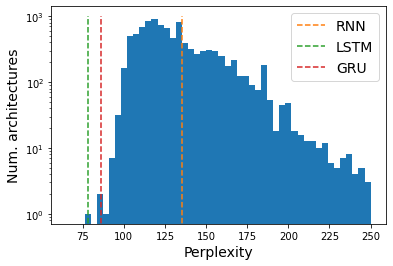

In [12]:
plt.hist([np.exp(np.min(x['test_losses'])) for x in all_stats if x['status'] == 'OK'], 
         bins=50, range=(65, 250));
plt.ylabel('Num. architectures', fontsize=14)
plt.xlabel('Perplexity', fontsize=14)
labels = ['RNN', 'LSTM', 'GRU']

for i in range(3):
    seek_id = recepie_ids.index(1000000 + i)
    x = ok_stats[seek_id]
    plt.vlines(np.exp(np.min(x['test_losses'])), 0, 1000, color=f'C{i+1}', label=labels[i], linestyle='--')
plt.legend(fontsize=14)
plt.yscale('log')
plt.savefig('data/figures/ppl_distrib.png', dpi=300, bbox_inches='tight')

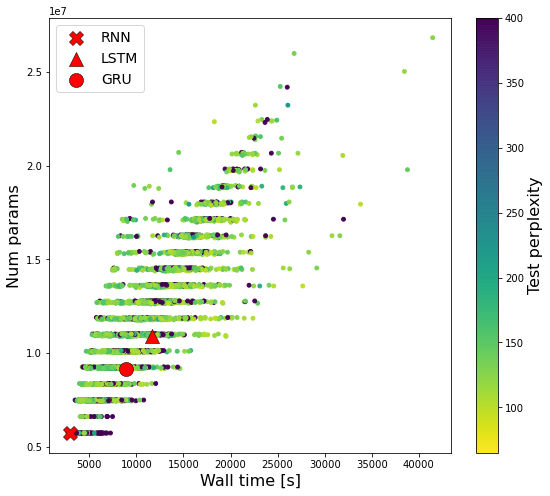

In [13]:
plt.figure(figsize=(9, 8))
plt.scatter([np.sum(x['wall_times']) for x in ok_stats], 
            [x['num_params'] for x in ok_stats], s=15,
            c=[(np.min(np.exp(x['test_losses']))) for x in ok_stats],
            cmap=plt.cm.viridis_r, alpha=0.99)
cbar = plt.colorbar()
cbar.set_label('Test perplexity', fontsize=16)
plt.clim([65, 400])

labels = ['RNN', 'LSTM', 'GRU']
markers = ['X', '^', 'o']
for i in range(3):
    seek_id = recepie_ids.index(1000000 + i)
    x = ok_stats[seek_id]
    plt.scatter([np.sum(x['wall_times'])],
                [x['num_params']],
                c='r', marker=markers[i], zorder=10, edgecolor='k', lw=0.5,
                s=200, label=labels[i])

plt.legend(fontsize=14)
plt.xlabel('Wall time [s]', fontsize=16)
plt.ylabel('Num params', fontsize=16)
plt.savefig('data/figures/main_metrics.png', dpi=300, bbox_inches='tight')

In [14]:
def get_rank(x):
    r = np.zeros_like(x)
    r[np.argsort(x)] = np.arange(len(x))
    return r

In [15]:
Y = np.array([x['test_losses'] for x in all_stats if x['status'] == 'OK'])

In [16]:
X = np.array([x['val_losses'] for x in all_stats if x['status'] == 'OK'])

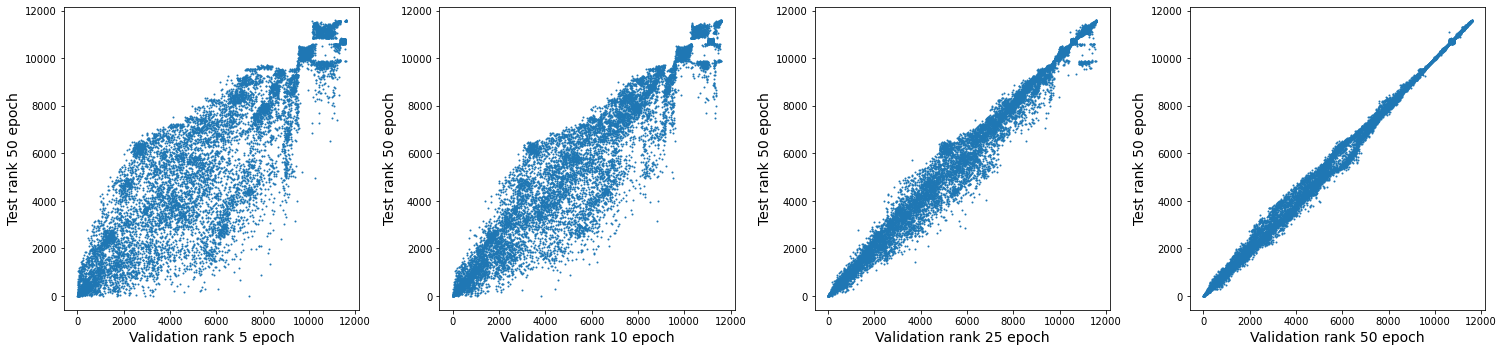

In [17]:
plt.figure(figsize=(21, 5))
for i, e in enumerate([5, 10, 25, 50]):
    plt.subplot(1, 4, i + 1)
    plt.scatter(get_rank(X[:, e - 1]), get_rank(Y[:, -1]), s=1)
    plt.xlabel(f'Validation rank {e} epoch', fontsize=14)
    plt.ylabel('Test rank 50 epoch', fontsize=14)
plt.tight_layout()
plt.savefig('data/figures/dynamic_ranking.png', dpi=300, bbox_inches='tight')

### Correlation with performance on wikitext

In [18]:
for fn in os.listdir('train_logs_multi_runs'):
    if fn.endswith('.json'):
        all_stats.append(json.load(open(os.path.join('train_logs_multi_runs', fn), 'r')))

In [19]:
all_stats_wiki = []
for fn in os.listdir('train_logs_wikitext-2'):
    if fn.endswith('.json'):
        all_stats_wiki.append(json.load(open(os.path.join('train_logs_wikitext-2', fn), 'r')))

In [20]:
len(all_stats_wiki)

345

In [21]:
ok_stats_wiki = [x for x in all_stats_wiki if x['status'] == 'OK']

In [22]:
id_to_ppl = {x['recepie_id']:np.exp(np.min(x['test_losses'])) for x in all_stats if x['status'] == 'OK'}
id_to_ppl_wiki = {x['recepie_id']:np.exp(np.min(x['test_losses'])) for x in all_stats_wiki if x['status'] == 'OK'}

In [23]:
ppl = []
ppl_wiki = []
for k in id_to_ppl_wiki:
    if k in id_to_ppl:
        ppl.append(id_to_ppl[k])
        ppl_wiki.append(id_to_ppl_wiki[k])

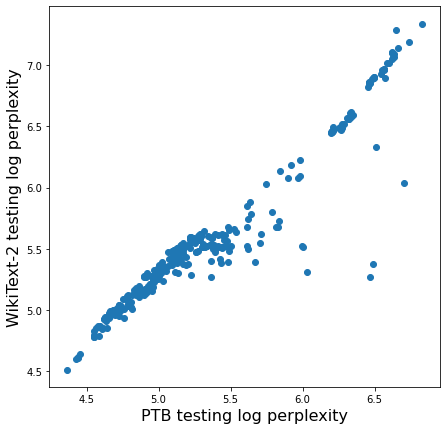

In [24]:
plt.figure(figsize=(7, 7))
plt.scatter(np.log(ppl), np.log(ppl_wiki))
plt.xlabel('PTB testing log perplexity', fontsize=16)
plt.ylabel('WikiText-2 testing log perplexity', fontsize=16)
plt.savefig('data/figures/transfer_corr.png', dpi=300, bbox_inches='tight')